In [54]:
import os

# copy these over to here for a backup development
efdir = "/home/julian/.local/share/godot/app_userdata/tunnelvr_v0.5/executingfeatures"
os.listdir(efdir)



['polygon.txt', 'surfacemesh.txt', 'mesh.txt', 'flattenedmesh.txt']

In [55]:
import json, numpy

polyfile = os.path.join(efdir, "polygon.txt")
x = json.loads(open(polyfile).readline())
vertices = numpy.array(x[0])
faces = numpy.array(x[1])

#var dc = "run -it --rm -v %s:/data -v %s:/code pymesh/pymesh /code/polytriangulator.py /data/polygon.txt %f /data/mesh.txt" % \
#    [ ProjectSettings.globalize_path("user://executingfeatures"), ProjectSettings.globalize_path("res://executingfeatures"), leng ]
#print(dc)
#pymeshpid = OS.execute("docker", PoolStringArray(dc.split(" ")), false)

fmeshname = os.path.join(efdir, "mesh.txt")
x = json.loads(open(fmeshname).readline())
fvertices = numpy.array(x[0])
ffaces = numpy.array(x[1]).reshape((-1, 3))



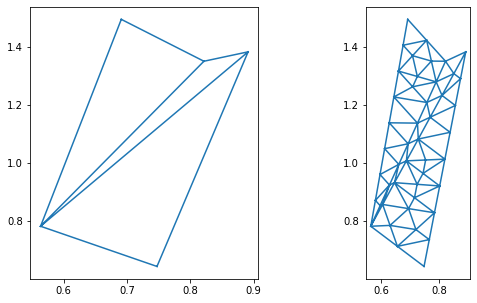

In [56]:
plt.figure(figsize=(9,5))
plt.subplot(121)
plt.triplot(vertices[:,0], vertices[:,1], faces)
plt.subplot(122)
plt.triplot(fvertices[:,0], fvertices[:,1], ffaces)
plt.gca().set_aspect('equal')


In [62]:

# this code will project it to 3D
# var xcdatalist = Centrelinedata.xcdatalistfromwingdata("res://surveyscans/wingform/Wing XYZ geometry.csv")

smeshname = os.path.join(efdir, "surfacemesh.txt")
x = json.loads(open(smeshname).readline())
svertices = numpy.array(x[0])
sfaces = numpy.array(x[1]).reshape((-1, 3))

flmeshname = os.path.join(efdir, "flattenedmesh.txt")
x = json.loads(open(flmeshname).readline())
flvertices = numpy.array(x)

for t in sfaces:
    p0, p1, p2 = svertices[t[0]], svertices[t[1]], svertices[t[2]]

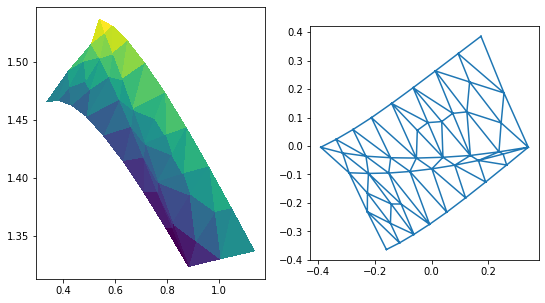

In [65]:
plt.figure(figsize=(9,5))
plt.subplot(121)
plt.tripcolor(svertices[:,0], svertices[:,1], sfaces, svertices[:,2])
plt.subplot(122)
plt.triplot(flvertices[:,0], flvertices[:,1], sfaces)
plt.gca().set_aspect('equal')
